# Using TensorFlow Extended (TFX): From ML Metadata to TF Transform

As it is described in its [official site](https://www.tensorflow.org/tfx), TFX package provides a sequence of components that implements an ML pipeline which is specifically designed for scalable, high-performance machine learning tasks. As it is componed by different libraries, each function can be applied individually. The following figure is the schema of those components:

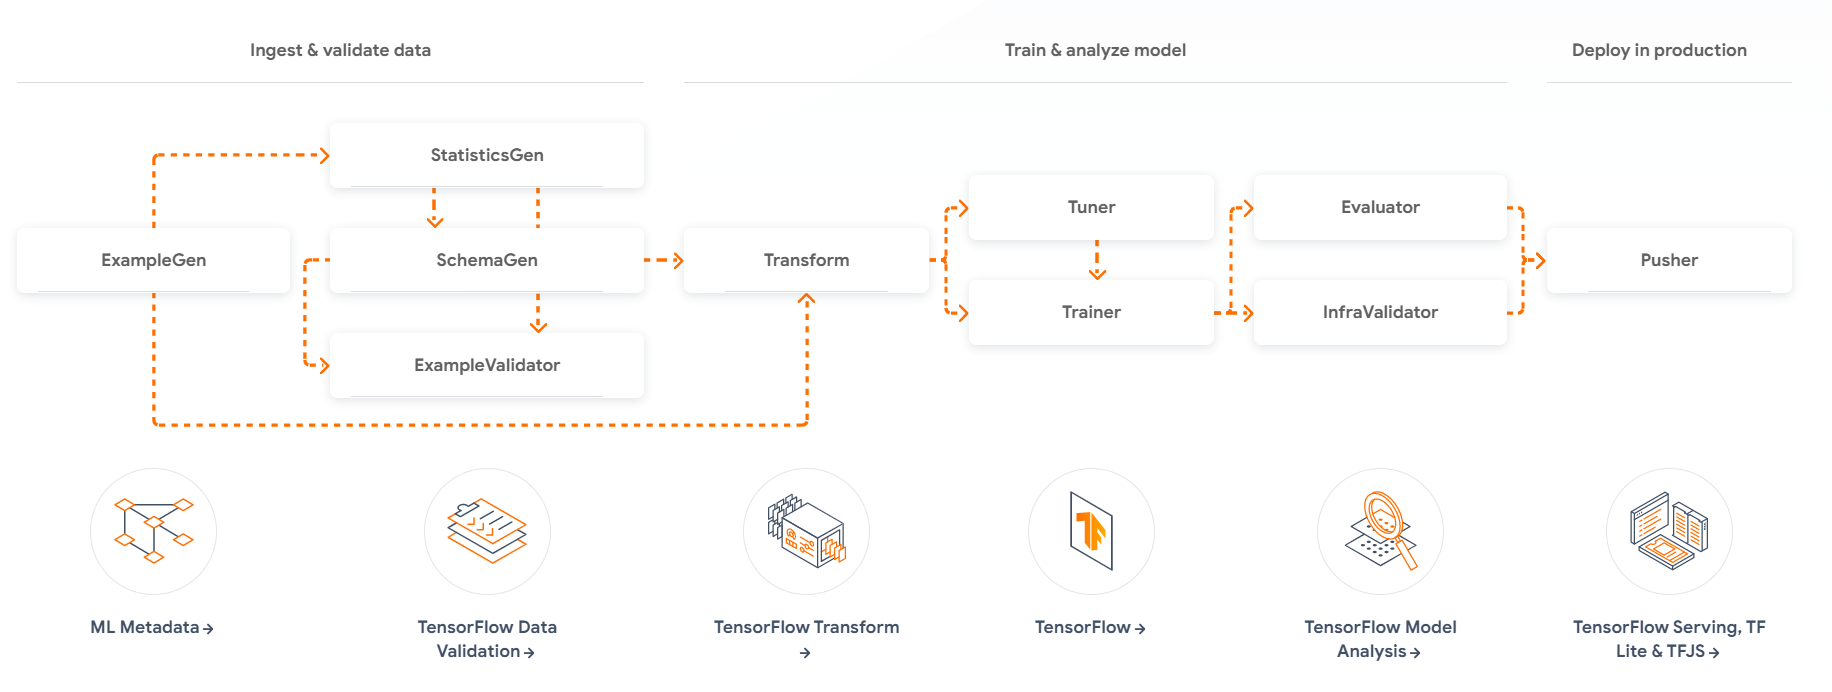

This script is aimed to implement the components of TFX with [THIS](https://www.kaggle.com/datasets/whenamancodes/alcohol-effects-on-study) data, specifically from convert it from ML Metadata, to use the Transform component. 

The following steps are:
1. Create dataframe and set the interactive context.
2. Use TFDV as TFX components (similarly to the used in [THIS](https://github.com/saraalgo/Feature-engineering-with-TF/blob/main/01-DataValidation_TF/DataValidation_TF.ipynb) script):
    - StatisticsGen
    - SchemaGen
    - ExampleValidator
3. Apply TFX with Transform component.

## Load packages

In [21]:
# Change Git path
import os 
CURRENT_PATH = os.getcwd()
os.chdir(CURRENT_PATH.split('Feature-engineering-with-TF',1)[0] + 'Feature-engineering-with-TF/02-FeatureEng_TFExtended')
from utils import *

# Essential packages
import pandas as pd

# TF package
import tensorflow as tf
from tfx.components import CsvExampleGen
from tfx.components import ExampleValidator
from tfx.components import SchemaGen
from tfx.components import StatisticsGen
from tfx.components import Transform

import tensorflow_transform.beam as tft_beam
from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext


# Omit warning messages from the following code
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## 1. Create dataframe and set the interactive context

Boths *.csv* from **/exdata** is unified and saved in a new folder: **/02-FeatureEng_TFExtended/data**.

In [11]:
# Read CSV files as dataframe
df_maths = pd.read_csv('../exdata/Alcohol-effects-study/Maths.csv', header=0)
df_port = pd.read_csv('../exdata/Alcohol-effects-study/Portuguese.csv', header=0)

# Adding them an extra column with the name of the subject and check that both have the same columns
df_maths.insert(0, 'Subject', 'Maths')
df_port.insert(0, 'Subject', 'Portuguese')

print(f'Both dataframes have the same column names: {df_maths.columns.equals(df_port.columns)}')

# Concatenate and print dataset
df = pd.concat([df_maths, df_port], ignore_index=True)

# Save new df in file
if not os.path.exists('./data'):
    os.makedirs('./data')

df.to_csv("./data/df_unified.csv",index=False)

Both dataframes have the same column names: True


It is recommended to set the paths for creating the interactive context with the data.

In [15]:
if not os.path.exists('./pipeline'):
        os.makedirs('./pipeline')
PIPELINE = './pipeline'
DATA = './data'
DF = './data/df_unified.csv'

# Interactive Context
context = InteractiveContext(pipeline_root=PIPELINE)

## 2. Use TFDV as TFX component

The first component of TFX is the [**ExampleGen**](https://www.tensorflow.org/tfx/guide/examplegen), which will split our data (by default: 2/3 train, 1/3 eval) at the moment of load it.

In [19]:
exgen = CsvExampleGen(input_base = DATA)

context.run(exgen)

ExecutionResult(
    component_id: CsvExampleGen
    execution_id: 3
    outputs:
        examples: OutputChannel(artifact_type=Examples, producer_component_id=CsvExampleGen, output_key=examples, additional_properties={}, additional_custom_properties={}))

To check that the df has been properly loaded it is possible to check some of the rows with the next chunk of code. The splits of the data are called artifacts.

In [23]:
# To get the path where is stored and read only the train split data
artifact = exgen.outputs['examples'].get()[0]
train_uri = os.path.join(artifact.uri, 'Split-train')
tfrecord = [os.path.join(train_uri, name) for name in os.listdir(train_uri)]
dataset = tf.data.TFRecordDataset(tfrecord, compression_type="GZIP")

# Retrieved one example of training to check that is correctly loaded
get_records(dataset, 1)

[{'features': {'feature': {'G3': {'int64List': {'value': ['6']}},
    'nursery': {'bytesList': {'value': ['eWVz']}},
    'age': {'int64List': {'value': ['18']}},
    'reason': {'bytesList': {'value': ['Y291cnNl']}},
    'G2': {'int64List': {'value': ['6']}},
    'higher': {'bytesList': {'value': ['eWVz']}},
    'Fedu': {'int64List': {'value': ['4']}},
    'goout': {'int64List': {'value': ['4']}},
    'traveltime': {'int64List': {'value': ['2']}},
    'Medu': {'int64List': {'value': ['4']}},
    'school': {'bytesList': {'value': ['R1A=']}},
    'studytime': {'int64List': {'value': ['2']}},
    'address': {'bytesList': {'value': ['VQ==']}},
    'Walc': {'int64List': {'value': ['1']}},
    'famsup': {'bytesList': {'value': ['bm8=']}},
    'romantic': {'bytesList': {'value': ['bm8=']}},
    'Mjob': {'bytesList': {'value': ['YXRfaG9tZQ==']}},
    'freetime': {'int64List': {'value': ['3']}},
    'activities': {'bytesList': {'value': ['bm8=']}},
    'guardian': {'bytesList': {'value': ['bW90a

To get the statistics from the ExampleGen, use the component [StatisticsGen](https://www.tensorflow.org/tfx/guide/statsgen).

In [26]:
statgen = StatisticsGen(examples=exgen.outputs['examples'])

context.run(statgen)
context.show(statgen.outputs['statistics'])

To get the schema under the the splits of data and the domains of the features the component [SchemaGen](https://www.tensorflow.org/tfx/guide/schemagen) is used.

In [29]:
schegen = SchemaGen(statistics=statgen.outputs['statistics'])

context.run(schegen)
context.show(schegen.outputs['schema'])

,Type,Presence,Valency,Domain
Feature name,,,,
'Dalc',INT,required,,-
'Fedu',INT,required,,-
'Fjob',STRING,required,,'Fjob'
'G1',INT,required,,-
'G2',INT,required,,-
'G3',INT,required,,-
'Medu',INT,required,,-
'Mjob',STRING,required,,'Mjob'
'Pstatus',STRING,required,,'Pstatus'


,Values
Domain,
'Fjob',"'at_home', 'health', 'other', 'services', 'teacher'"
'Mjob',"'at_home', 'health', 'other', 'services', 'teacher'"
'Pstatus',"'A', 'T'"
'Subject',"'Maths', 'Portuguese'"
'activities',"'no', 'yes'"
'address',"'R', 'U'"
'famsize',"'GT3', 'LE3'"
'famsup',"'no', 'yes'"
'guardian',"'father', 'mother', 'other'"
